In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

In [21]:
from analysis import *
import mdtraj
import numpy as np
import ot

In [3]:
ih_id_res = {}

# Intramolecular H-Bond

## Load Trajectory

In [4]:
gnn_traj = load_parallel_traj(nrep=128,file="Example_analysis_trajectories/im_gnn.h5")
tip3p_trajectory = mdtraj.load("Example_analysis_trajectories/im_tip3p.h5")

/localhome/kpaul/.conda/envs/newest_pyg/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


## Get distances of interest

In [5]:
tip3p_dis = get_distance_by_name(tip3p_trajectory,*('O2','H13'))
gnn_dis = get_distance_by_name(gnn_traj,*('O2','H13'))

## Plot Free Energy

(0.0, 15.0)

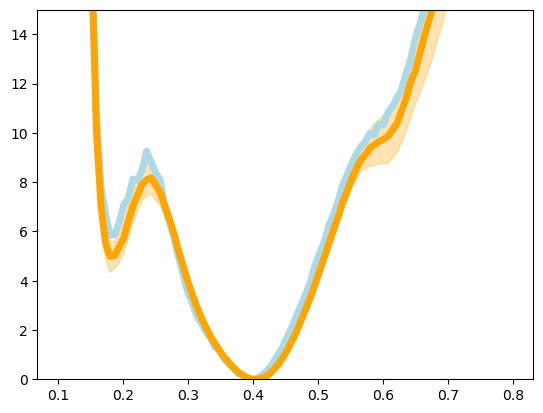

In [6]:
ax = plt.subplot()
nbins = 100
drange=(0.1,0.8)
plot_free_energy(ax,tip3p_dis,nbins,label='TIP3P',color='lightblue',range=drange)
plot_free_energy(ax,gnn_dis,nbins,label='GNN',color='orange',range=drange)
ax.set_ylim(0,15)

## Calculate Wasserstein Distance

In [7]:
gnn_wd = get_wasserstein_distance(tip3p_dis[:,0],np.concatenate(gnn_dis),nbins=nbins,drange=drange)
print(f"Wasserstein distance: {gnn_wd:.2f}")

Wasserstein distance: 0.05


# Conformational Ensemble

In [9]:
ce_tip3p = mdtraj.load("Example_analysis_trajectories/ce_tip3p.h5")
ce_gnn = load_parallel_traj(nrep=128,file="Example_analysis_trajectories/ce_gnn.h5")

/localhome/kpaul/.conda/envs/newest_pyg/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


## Free Energy

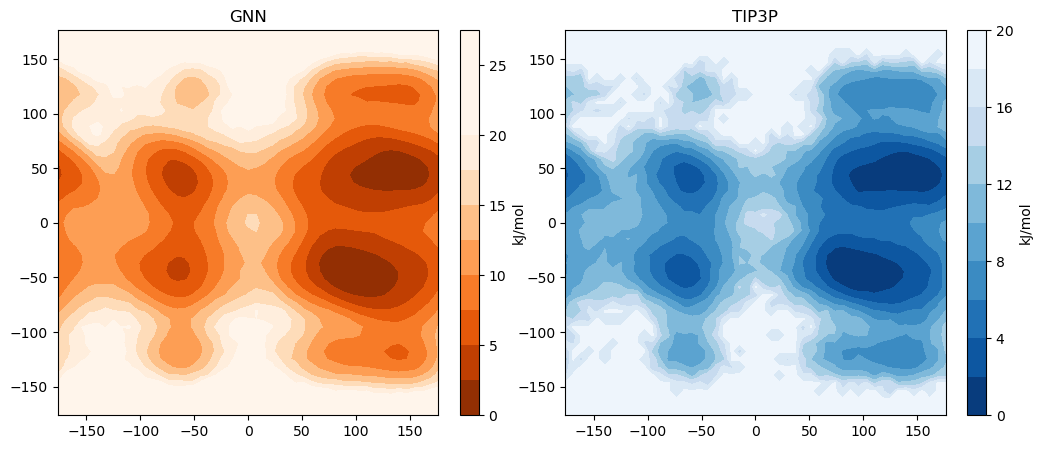

In [20]:
num_bins = 50
levels = 10
torsion_dict ={0:[('C7','C6','C5','N1'),('C5','N1','C4','C3')]}

tip3p_d1 = get_dihedrals_by_name(ce_tip3p,*torsion_dict[0][0])
tip3p_d2 = get_dihedrals_by_name(ce_tip3p,*torsion_dict[0][1])
x,y,tip3p_kjz = get_xyz(tip3p_d1.T[0],tip3p_d2.T[0],num_bins)

gnn_d1 = np.concatenate(get_dihedrals_by_name(ce_gnn,*torsion_dict[0][0]))
gnn_d2 = np.concatenate(get_dihedrals_by_name(ce_gnn,*torsion_dict[0][1]))
_,_,gnn_kjz = get_xyz(gnn_d1.T[0],gnn_d2.T[0],num_bins)

fig, axd = plt.subplots(1,2,figsize=(12,5))
gnnf = axd[0].contourf(x/np.pi*180,y/np.pi*180,gnn_kjz,levels=levels,cmap='Oranges_r',vmax=20)
axd[0].set_title("GNN")
tip3pf = axd[1].contourf(x/np.pi*180,y/np.pi*180,tip3p_kjz,levels=levels,cmap='Blues_r',vmax=20)
axd[1].set_title("TIP3P")

cbar = fig.colorbar(gnnf, ax=axd[0], orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('kJ/mol')
cbar2 = fig.colorbar(tip3pf, ax=axd[1], orientation='vertical', fraction=0.05, pad=0.05)
cbar2.set_label('kJ/mol')
plt.show()

## Wasserstein Distance

In [29]:
_,_,prob_tip3p = get_prob(tip3p_d1.flatten(), tip3p_d2.flatten(), num_bins)
_,_,prob_gnn = get_prob(gnn_d1.flatten(), gnn_d2.flatten(), num_bins)

M = ot.dist(prob_tip3p, prob_gnn)
wass_dist = ot.emd2([], [], M)

print(f"Wasserstein distance: {wass_dist:.4f}")

Wasserstein distance: 0.0058


## Clustering

In [40]:
def create_pairs(d1_1x500,d2_1x500):
    num_bins = 100
    x,y,kjz = get_xyz(d1_1x500,d2_1x500,num_bins,bins=np.linspace(0,2*np.pi,num_bins))
    coords = []
    energies = []
    maxkjz = np.max(kjz)
    for i in range(len(x)):
        for j in range(len(y)):
            if kjz[j,i] != maxkjz:
                coords.append([x[i],y[j]])
                energies.append(kjz[j,i])
    coords = np.array(coords)
    energies = np.array(energies)

    return coords,energies

def cluster_pairs(num_clusters,coords,energies):

    from ebc import EBC
    np.random.seed(161311)
    ebc = EBC(n_clusters=num_clusters,boxsize=2*np.pi,proto_radius=0.1)
    labels = ebc.fit_transform(np.array(coords),np.array(energies))

    return labels

In [38]:
coords, energies = create_pairs(tip3p_d1.flatten()+ np.pi ,tip3p_d2.flatten()+ np.pi )
tip3p_labels = cluster_pairs(8,coords,energies)

Using 1240 proto clusters.
Using the eigenvector corresponding to an eigenvalue of 1.0000000000000009.


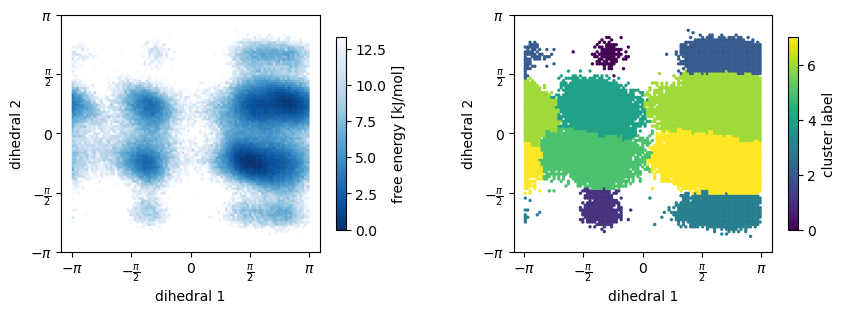

In [39]:
fig, axd = plt.subplot_mosaic([['energy','clustering']],figsize=(15,5))
fig.set_size_inches(10,5)
colorbar1 = axd['energy'].scatter(coords[:,0],coords[:,1],c=energies,s=2,cmap='Blues_r')
colorbar2 = axd['clustering'].scatter(coords[:,0],coords[:,1],c=tip3p_labels,s=2,cmap=None)

for ax in axd.values():
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('dihedral 1')
    ax.set_ylabel('dihedral 2')
    ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],labels=[r'$-\pi$',r'$-\frac{\pi}{2}$','0',r'$\frac{\pi}{2}$',r'$\pi$'])
    ax.set_yticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi],labels=[r'$-\pi$',r'$-\frac{\pi}{2}$','0',r'$\frac{\pi}{2}$',r'$\pi$'])

# set space between plots
fig.subplots_adjust(wspace=0.4)

plt.colorbar(colorbar1,ax=axd['energy'],label='free energy [kJ/mol]',shrink=0.5)
plt.colorbar(colorbar2,ax=axd['clustering'],label='cluster label',shrink=0.5)

## Effective Sampling Rate

In [54]:
gnn_coords = np.concatenate((gnn_d1 + np.pi,gnn_d2 + np.pi),axis=1)
gnn_cluster_assignments = get_cluster_assignment_multiple_parallel(coords,gnn_coords,tip3p_labels)

frames = [1] + [i*100 for i in range(1,50)]
all_shifts = []

8

In [81]:
results = []
for f in frames:
    nofc = []
    for i in range(100):
        nofc.append(len(set(gnn_cluster_assignments[i*f:(i+1)*f])))
    results.append(np.mean(nofc))

Text(0, 0.5, 'Number of clusters')

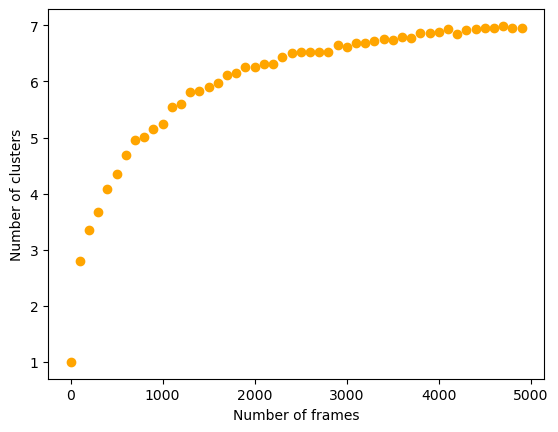

In [82]:
marker_style = dict(fmt='o', markersize=10, markeredgecolor='white')
plt.scatter(frames,results,color='orange',label='GNN')
plt.xlabel('Number of frames')
plt.ylabel('Number of clusters')